# Web Scraping and Data Wrangling

Import the necessary libraries for Data Analysis

In [1]:
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import requests
import geocoder
import folium

Get the content of the website containing <b>Quezon City's</b> zipcodes.

In [2]:
result = requests.get("http://www.lhiza.com/zipcodes/quezonci.htm")
content = result.content

Initialize beautifulsoup and insert the content of the site as the parameter.

In [3]:
soup = BeautifulSoup(content)

Find the first table and find all the table rows after the first row(the first row is just the table header) inside the table and create a dataframe containing the location along with their corresponding zip code.

In [4]:
codes = soup.findAll('table')[0].findAll('tr')[1:]
l = []
for code in codes:
    place = code.findAll('td')
    l.append({
        'Location': place[0].string,
        'Code': place[1].string
    })
df = pd.DataFrame(l)

Look at the shape of the dataframe and print the first five rows.

In [5]:
print(df.shape)
df.head()

(148, 2)


,Code,Location
0,1105,Alicia
1,1102,Amihan
2,1106,Apolonio Samson
3,1106,Baesa
4,1116,Bagbag


There are 148 rows of location-zipcode pairs.

We'll then use geocoder to utilize google's geocoding api inorder to retrieve the latitude and longitude of the locations or zipcodes in Quezon City. After that, we'll add the longitude and latitudes to the original dataframe. If the location does not exist in the google geocoding api, we'll use the zipcode instead, and if the latitude and longitude still doesn't exist, we'll use arcGIS' geocoder instead.

In [6]:
GOOGLE_API_KEY = "SET GOOGLE API KEY HERE"
for i in range(len(df)):
    postcode = df.iloc[i]['Code']
    location = df.iloc[i]['Location']
    g = geocoder.google('{}, Quezon City, Philippines'.format(location), key=GOOGLE_API_KEY)
    lat_lng_coords = g.latlng
    if not lat_lng_coords:
        g = geocoder.google('{}, Philippines'.format(postcode), key=GOOGLE_API_KEY)
        lat_lng_coords = g.latlng
        if not lat_lng_coords:
            g = geocoder.arcgis('{}, Philippines'.format(postcode))
            lat_lng_coords = g.latlng
    df_index = df.index[i]
    df.loc[df_index, 'Latitude'] = lat_lng_coords[0]
    df.loc[df_index, 'Longitude'] = lat_lng_coords[1]
df.head()

,Code,Location,Latitude,Longitude
0,1105,Alicia,14.661434,121.025268
1,1102,Amihan,14.632086,121.068624
2,1106,Apolonio Samson,14.655931,121.007706
3,1106,Baesa,14.671225,121.011409
4,1116,Bagbag,14.696551,121.032464


Since some areas or locations in the dataframe have equal latitudes and longtiudes, we drop those duplicates from the dataframe. The number of rows drop down to 143 rows of unique latitudes and longtiudes.

In [7]:
df = df.drop_duplicates(subset=['Latitude', 'Longitude'], keep='first')
df.shape

(143, 4)

We create a folium map that's centered at the latitude and longitude to where <b>Vasra</b>, a location within Quezon City belongs to. We then loop through each location in the dataframe and plot out a blue circle of radius 500 in each location's latitude and longitude.

In [8]:
g = geocoder.arcgis('1128, Philippines')
lat_lng_coords = g.latlng
latitude = lat_lng_coords[0]
longitude = lat_lng_coords[1]

quezon_map = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lng, location, code in zip(df['Latitude'], df['Longitude'], df['Location'], df['Code']):
    label = '{}, {}'.format(location, code)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=500,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(quezon_map)  
    
quezon_map

Create the variables that'll be sent as parameters to the Foursquare api later.

In [70]:
CLIENT_ID = 'ID_HERE' # your Foursquare ID
CLIENT_SECRET = 'SECRET_HERE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
LIMIT = 500
radius = 500

Your credentails:
CLIENT_ID: ID_HERE
CLIENT_SECRET:SECRET_HERE


Create the function that'll call the Foursquare api with the variables created earlier as additional parameters, the call will retrieve the venues of "Food" category, it'll print the locations wherein there are no venues nearby. The function will return a dataframe containing each restaurant found along with their category, location, latitude and longitude.

In [10]:
def get_restaurants(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL filtering by Food Category
        url = 'https://api.foursquare.com/v2/venues/search?&categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['venues']
        except KeyError:
            print("no restaurants: {} ".format(name))
            continue;
            
        if len(results) == 0:
            print("no restaurants: {} ".format(name))
        
        # return only relevant information for each nearby venue
        for v in results:
            try:
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['name'], 
                    v['location']['lat'], 
                    v['location']['lng'],  
                    v['categories'][0]['name'])])
            except IndexError:
                print("Index Error: {}".format(v['name']))

    nearby_restaurants = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_restaurants.columns = ['Location', 
                  'Location Latitude', 
                  'Location Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_restaurants)

Call the function created and pass the dataframe containing the Quezon City postcodes and locations along with the radius while saving the returned dataframe to the variable quezon_restaurants.

In [11]:
quezon_restaurants = get_restaurants(names=df['Location'],
                                latitudes=df['Latitude'],
                                longitudes=df['Longitude'],
                                radius=radius
                                )

Display the first five rows of the quezon_restaurants dataframe.

In [12]:
quezon_restaurants.head()

,Location,Location Latitude,Location Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alicia,14.661434,121.025268,Jollibee,14.659871,121.025813,Fast Food Restaurant
1,Alicia,14.661434,121.025268,Lechon Haus,14.659645,121.029308,Filipino Restaurant
2,Alicia,14.661434,121.025268,The Federal : Modern Chinese Bistro,14.664843,121.022188,Chinese Restaurant
3,Alicia,14.661434,121.025268,Pancit Malabon Shorthorn,14.665074,121.022135,Noodle House
4,Alicia,14.661434,121.025268,Dunkin' Donuts,14.657516,121.022902,Donut Shop


Display the last five rows of the quezon_restaurants dataframe.

In [13]:
quezon_restaurants.tail()

,Location,Location Latitude,Location Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
6104,White Plains,14.606341,121.072206,Happy Bakery,14.608128,121.077608,Bakery
6105,White Plains,14.606341,121.072206,Smokin' Cues,14.605312,121.070162,BBQ Joint
6106,White Plains,14.606341,121.072206,Bagoong Club Resto,14.603103,121.069477,Filipino Restaurant
6107,White Plains,14.606341,121.072206,Sizzling Steak,14.603118,121.068570,Latin American Restaurant
6108,White Plains,14.606341,121.072206,Ghenna's Cafe,14.602296,121.074858,Café


Using matplotlib, we'll create a horizontal bar plot that plots the amount of restaurants for each restaurant category in the quezon_restaurants dataframe.

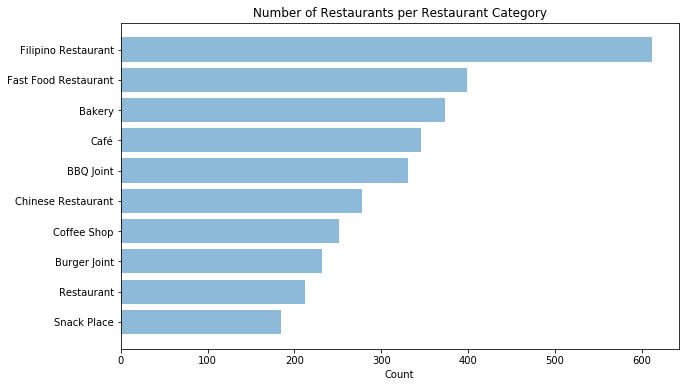

In [63]:
restaurant_cat = quezon_restaurants['Venue Category'].value_counts()
restaurants = list(restaurant_cat.index[0:10])
y_pos = np.arange(len(restaurants))
number = restaurant_cat[0:10]

plt.barh(y_pos, number, align='center', alpha=0.5)
plt.yticks(y_pos, restaurants)
plt.xlabel('Count')
plt.title('Number of Restaurants per Restaurant Category')
plt.gca().invert_yaxis()

plt.rcParams['figure.figsize'] = (10, 6)
plt.show()

Filipino restaurants are shown to be the most common restaurant category with almost a hundred instances, followed by Fast food restaurants, then by bakeries.

We'll then perform one-hot encoding on the <b>Venue Category</b> column, which implies the category of the restaurant for later use in clustering. 

In [16]:
# one hot encoding
quezon_onehot = pd.get_dummies(quezon_restaurants[['Venue Category']], prefix="", prefix_sep="")

# add location column back to dataframe
quezon_onehot['Location'] = quezon_restaurants['Location'] 

# move location column to the first column
fixed_columns = [quezon_onehot.columns[-1]] + list(quezon_onehot.columns[:-1])
quezon_onehot = quezon_onehot[fixed_columns]

quezon_onehot.head()

,Location,Afghan Restaurant,American Restaurant,Arcade,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Tapas Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Alicia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Alicia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Alicia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Alicia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Alicia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We'll then group rows together by location, getting the mean of each category for each location, which would then imply weight of the category's rarity for that said location.

In [17]:
quezon_grouped = quezon_onehot.groupby('Location').mean().reset_index()
quezon_grouped.head()

,Location,Afghan Restaurant,American Restaurant,Arcade,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Tapas Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Alicia,0.0,0.020833,0.0,0.0,0.041667,0.0,0.041667,0.000000,0.020833,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020833
1,Amihan,0.0,0.000000,0.0,0.0,0.040816,0.0,0.000000,0.020408,0.081633,...,0.020408,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020408
2,Apolonio Samson,0.0,0.000000,0.0,0.0,0.055556,0.0,0.111111,0.000000,0.138889,...,0.000000,0.027778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,BF Homes,0.0,0.000000,0.0,0.0,0.051282,0.0,0.025641,0.000000,0.051282,...,0.000000,0.051282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,Baesa,0.0,0.000000,0.0,0.0,0.000000,0.0,0.095238,0.000000,0.000000,...,0.000000,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


Just to visualize each location's most common restaurant category near it, we'll create a function that returns the <b>n</b> most common restaurant categories near it. We'll then create a dataframe with the column 'Location' along with the top 5 most common restaurant categories near the location, and we'll call this dataframe, quezon_sorted.

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Location']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
quezon_sorted = pd.DataFrame(columns=columns)
quezon_sorted['Location'] = quezon_grouped['Location']

for ind in np.arange(quezon_grouped.shape[0]):
    quezon_sorted.iloc[ind, 1:] = return_most_common_venues(quezon_grouped.iloc[ind, :], num_top_venues)

print(quezon_sorted.shape)
quezon_sorted.head()

(143, 6)


,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Alicia,Filipino Restaurant,Juice Bar,Fast Food Restaurant,Japanese Restaurant,Chinese Restaurant
1,Amihan,Filipino Restaurant,Burger Joint,Bakery,Chinese Restaurant,Café
2,Apolonio Samson,Bakery,Café,BBQ Joint,Filipino Restaurant,Pizza Place
3,BF Homes,Filipino Restaurant,Snack Place,Korean Restaurant,Asian Restaurant,Bakery
4,Baesa,Fast Food Restaurant,Snack Place,Chinese Restaurant,BBQ Joint,Filipino Restaurant


# Modeling and Evaluation


K-Means Clustering will be performed on the dataframe, removing Location from the dataframe so that the data will solely be the weights of the categories.

One of the problems in K-means Clustering is finding the proper K as a parameter. To find the proper K, we'll use the average silhouette method to find the number of clusters to use for our clustering.

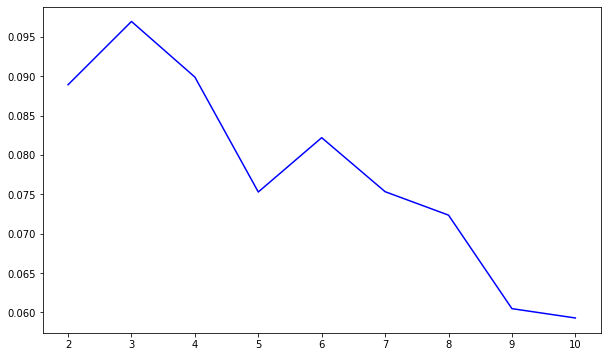

In [20]:
num_of_cluster = range(2,11)
x = range(2, 11)
y = []
y_silhouette = []
quezon_grouped_clustering = quezon_grouped.drop('Location', 1)
for kclusters in num_of_cluster:
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(quezon_grouped_clustering)
    label = kmeans.labels_
    y_silhouette.append(silhouette_score(quezon_grouped_clustering, label, metric='euclidean'))
plt.plot(x, y_silhouette, 'b-')
plt.show()

With the average silhouette score as the score basis, our highest point is achieved when k is 3, so we'll choose 3 as our optimum number of clusters to use. 

We'll then perform K-means clustering again with 5 as the cluster parameter.

In [24]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(quezon_grouped_clustering)
kmeans.labels_[0:10] 

array([2, 1, 1, 1, 2, 1, 2, 1, 1, 2], dtype=int32)

We'll now add the cluster labels to the quezon_sorted dataframe(the dataframe which contains the location and the top 5 most common restaurant venues near it). 

We'll also add 1 to our cluster label so that the first cluster starts at cluster 1 instead of 0 which improves readability.

In [25]:
# add clustering labels
quezon_sorted['Cluster Labels'] = kmeans.labels_
quezon_merged = df.copy()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
quezon_merged = quezon_merged.join(quezon_sorted.set_index('Location'), on='Location').reset_index()

quezon_merged['Cluster Labels'] += 1
quezon_merged.head() # check the last columns!

,index,Code,Location,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
0,0,1105,Alicia,14.661434,121.025268,Filipino Restaurant,Juice Bar,Fast Food Restaurant,Japanese Restaurant,Chinese Restaurant,3
1,1,1102,Amihan,14.632086,121.068624,Filipino Restaurant,Burger Joint,Bakery,Chinese Restaurant,Café,2
2,2,1106,Apolonio Samson,14.655931,121.007706,Bakery,Café,BBQ Joint,Filipino Restaurant,Pizza Place,2
3,3,1106,Baesa,14.671225,121.011409,Fast Food Restaurant,Snack Place,Chinese Restaurant,BBQ Joint,Filipino Restaurant,3
4,4,1116,Bagbag,14.696551,121.032464,Bakery,Fast Food Restaurant,Soup Place,BBQ Joint,Comfort Food Restaurant,2


We'll know create and show the folium map which shows the same map as before but now showing different colors for each circle according to their cluster membership.

In [26]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 2, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(quezon_merged['Latitude'], quezon_merged['Longitude'], quezon_merged['Location'], quezon_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

We'll then look at what locations belong to each cluster and show a vertical bar graph that depicts the top 5 most common restaurant categories within the cluster.

The cluster names are based on their top most common restaurant category.

We'll first look at Cluster 1 - Burger Joint Cluster.

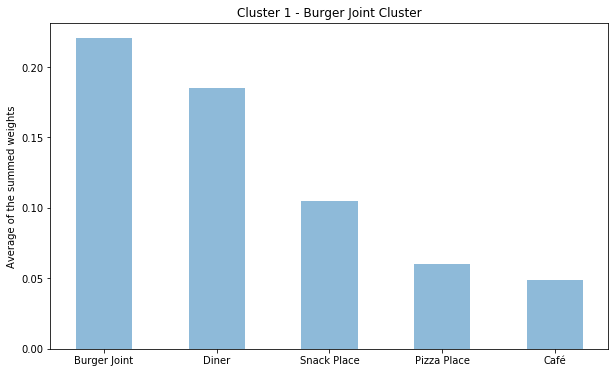

,index,Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
0,21,1117,Diner,Pizza Place,Burger Joint,Snack Place,Wings Joint,1
1,31,1123,Burger Joint,Soup Place,Snack Place,Japanese Restaurant,Café,1
2,74,1125,Burger Joint,Diner,Restaurant,Food Court,Filipino Restaurant,1
3,87,1107,Diner,Asian Restaurant,Filipino Restaurant,Café,Ice Cream Shop,1
4,116,1117,Fast Food Restaurant,Burger Joint,Breakfast Spot,Snack Place,Coffee Shop,1


In [64]:
cluster_zero_members = quezon_merged.loc[quezon_merged['Cluster Labels'] == 1]
summed_means = quezon_grouped[quezon_grouped['Location'].isin(cluster_zero_members['Location'])].sum()[1:]
mean_categories = (summed_means/len(cluster_zero_members)).sort_values(ascending=False)

restaurants = list(mean_categories.index[0:5])
y_pos = np.arange(len(restaurants))
number = mean_categories[0:5]

plt.bar(y_pos, number, align='center', alpha=0.5, width=0.5)
plt.xticks(y_pos, restaurants)
plt.ylabel('Average of the summed weights')
plt.title('Cluster 1 - Burger Joint Cluster')

plt.rcParams['figure.figsize'] = (10, 6)
plt.show()


quezon_merged.loc[quezon_merged['Cluster Labels'] == 1, quezon_merged.columns[[1] + list(range(5, quezon_merged.shape[1]))]].reset_index()

In the first cluster, which only has 5 locations, we can notice that burger joints are very common in those locations, those locations may prefer lighter meals as opposed to the regular restaurants that offer main courses. A contributing factor to that insight is that Snack Place is the third most common category within that cluster, followed by Pizza Place which is commonly a good place to go to for snacks.


We'll then look at Cluster 2 - Filipino Restaurant Cluster.

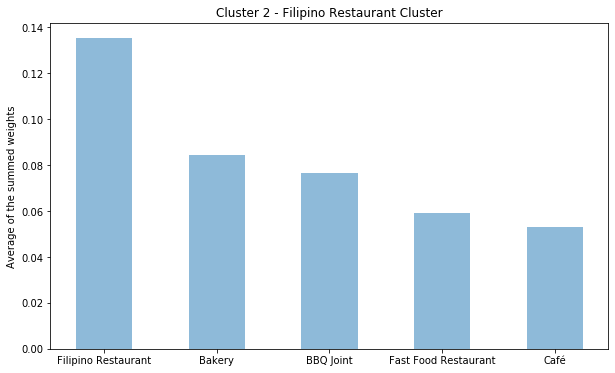

,index,Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
0,1,1102,Filipino Restaurant,Burger Joint,Bakery,Chinese Restaurant,Café,2
1,2,1106,Bakery,Café,BBQ Joint,Filipino Restaurant,Pizza Place,2
2,4,1116,Bakery,Fast Food Restaurant,Soup Place,BBQ Joint,Comfort Food Restaurant,2
3,5,1109,Burger Joint,Chinese Restaurant,Bakery,Filipino Restaurant,Diner,2
4,6,1111,Filipino Restaurant,Café,Fast Food Restaurant,Diner,Restaurant,2


In [65]:
cluster_two_members = quezon_merged.loc[quezon_merged['Cluster Labels'] == 2]
summed_means = quezon_grouped[quezon_grouped['Location'].isin(cluster_two_members['Location'])].sum()[1:]
mean_categories = (summed_means/len(cluster_two_members)).sort_values(ascending=False)

restaurants = list(mean_categories.index[0:5])
y_pos = np.arange(len(restaurants))
number = mean_categories[0:5]

plt.bar(y_pos, number, align='center', alpha=0.5, width=0.5)
plt.xticks(y_pos, restaurants)
plt.ylabel('Average of the summed weights')
plt.title('Cluster 2 - Filipino Restaurant Cluster')

plt.show()



quezon_merged.loc[quezon_merged['Cluster Labels'] == 2, quezon_merged.columns[[1] + list(range(5, quezon_merged.shape[1]))]].reset_index().head()

In [66]:
quezon_merged.loc[quezon_merged['Cluster Labels'] == 2, quezon_merged.columns[[1] + list(range(5, quezon_merged.shape[1]))]].reset_index().tail()

,index,Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
69,130,1116,Bakery,Filipino Restaurant,Snack Place,Asian Restaurant,BBQ Joint,2
70,135,1101,Café,Snack Place,Food Stand,Filipino Restaurant,BBQ Joint,2
71,137,1128,Filipino Restaurant,BBQ Joint,Restaurant,Fast Food Restaurant,Bakery,2
72,139,1109,Filipino Restaurant,Bakery,BBQ Joint,Middle Eastern Restaurant,Restaurant,2
73,142,1110,Filipino Restaurant,Restaurant,BBQ Joint,Snack Place,Bakery,2


In this cluster, we can notice that locations usually have Filipino Restaurants being the top most common restaurants. People in those locations may prefer more traditional types of dining.

Let's take a look at Cluster 3 - Fast Food Restaurant Cluster.

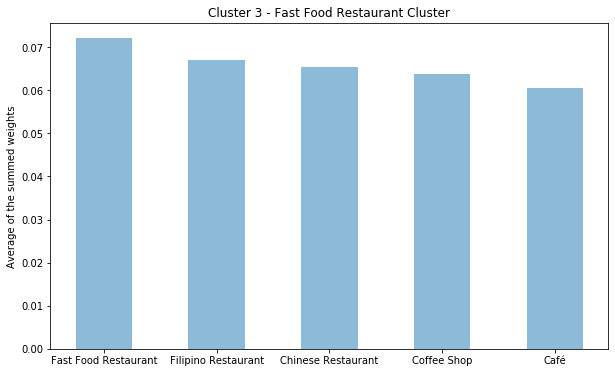

,index,Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
0,0,1105,Filipino Restaurant,Juice Bar,Fast Food Restaurant,Japanese Restaurant,Chinese Restaurant,3
1,3,1106,Fast Food Restaurant,Snack Place,Chinese Restaurant,BBQ Joint,Filipino Restaurant,3
2,7,1105,Coffee Shop,Japanese Restaurant,Ramen Restaurant,Filipino Restaurant,Bubble Tea Shop,3
3,8,1119,BBQ Joint,Korean Restaurant,Coffee Shop,Japanese Restaurant,Filipino Restaurant,3
4,9,1110,Snack Place,Café,Breakfast Spot,Coffee Shop,Pizza Place,3


In [67]:
cluster_three_members = quezon_merged.loc[quezon_merged['Cluster Labels'] == 3]
summed_means = quezon_grouped[quezon_grouped['Location'].isin(cluster_three_members['Location'])].sum()[1:]
mean_categories = (summed_means/len(cluster_three_members)).sort_values(ascending=False)

restaurants = list(mean_categories.index[0:5])
y_pos = np.arange(len(restaurants))
number = mean_categories[0:5]

plt.bar(y_pos, number, align='center', alpha=0.5, width=0.5)
plt.xticks(y_pos, restaurants)
plt.ylabel('Average of the summed weights')
plt.title('Cluster 3 - Fast Food Restaurant Cluster')

plt.show()

quezon_merged.loc[quezon_merged['Cluster Labels'] == 3, quezon_merged.columns[[1] + list(range(5, quezon_merged.shape[1]))]].reset_index().head()

In [68]:
quezon_merged.loc[quezon_merged['Cluster Labels'] == 3, quezon_merged.columns[[1] + list(range(5, quezon_merged.shape[1]))]].reset_index().tail()

,index,Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
59,134,1106,Filipino Restaurant,Bakery,Dessert Shop,Fast Food Restaurant,Japanese Restaurant,3
60,136,1112,Chinese Restaurant,Pizza Place,Fast Food Restaurant,Donut Shop,Ramen Restaurant,3
61,138,1105,Fast Food Restaurant,Filipino Restaurant,Fried Chicken Joint,Donut Shop,Chinese Restaurant,3
62,140,1120,Japanese Restaurant,Asian Restaurant,BBQ Joint,Wings Joint,Doner Restaurant,3
63,141,1104,Chinese Restaurant,Café,Filipino Restaurant,Bakery,Dim Sum Restaurant,3


In this cluster, we can notice that the scores of the top 5 categories are very close to each other. Locations in Cluster 3 may be busy locations where there are a lot of restaurants and people. People in this cluster may also have a wide array of preferences for restaurants, they may enjoy eating at different types of restaurants regularly.

Let's then look at a chart containing the amount of location for each cluster within Quezon City.

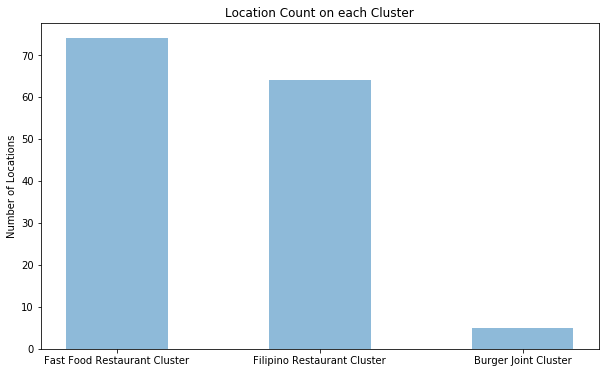

In [69]:
values = quezon_merged['Cluster Labels'].value_counts()
restaurants = ['Fast Food Restaurant Cluster',
               'Filipino Restaurant Cluster',
               'Burger Joint Cluster',]
y_pos = np.arange(len(restaurants))
number = values[0:3]

plt.bar(y_pos, number, align='center', alpha=0.5, width=0.5)
plt.xticks(y_pos, restaurants)
plt.ylabel('Number of Locations')
plt.title('Location Count on each Cluster')

plt.show()

We can see that the first cluster, the <b>Fastfood Restaurant Cluster</b> has the most locations belonging to that cluster followed by <b>Filipino Restaurant Cluster</b>. These two clusters have a small difference in number of locations between each other as compared to the <b>Burger Joint Cluster</b> which makes up the least amount of locations falling inside the cluster.

It is evident that Filipino Restaurants are frequently present inside Quezon City locations, but the fact that Quezon City is inside the Philippines could be an obvious factor as to why.